In [10]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, 
    array_to_img, 
    img_to_array, 
    load_img
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import os
import random
import shutil

## Working with Images

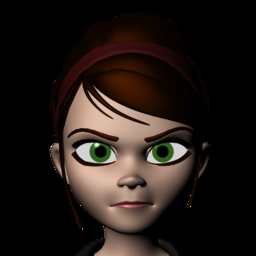

In [2]:
path_to_image = os.path.join(os.getcwd(), "data", "mery", "mery_anger", "mery_anger_1.png")

image = load_img(path_to_image)

image

In [3]:
type(image)

PIL.Image.Image

In [4]:
# Converting from PIL image types to numpy arrays is easy. Explore some properties:
img_array = img_to_array(image)
print(img_array.shape)
print(img_array.max())
print(img_array.min())

(256, 256, 3)
255.0
0.0


In [5]:
# Conversely, numpy arrays can be easilz turned into PIL images
array_to_img(img_array).size

(256, 256)

### Understanding `ImageDataGenerator` for Data Augmentation

When training deep learning models, especially in computer vision tasks, having a large dataset is crucial for improving model generalization and performance. However, collecting a large dataset can be challenging. This is where **data augmentation** helps.

#### What is `ImageDataGenerator`?
The `ImageDataGenerator` class in Keras provides a way to augment image data by applying random transformations to images in each batch during training. This helps improve model robustness and prevents overfitting.

#### Code Breakdown:

Each parameter in `ImageDataGenerator` applies a specific transformation:

- `rotation_range=40`: Rotates images randomly within a range of ±40 degrees.
- `width_shift_range=0.2`: Shifts the image horizontally by up to 20% of the image width.
- `height_shift_range=0.2`: Shifts the image vertically by up to 20% of the image height.
- `rescale=1./255`: Normalizes pixel values by scaling them between 0 and 1.
- `shear_range=0.2`: Applies a shear transformation with a magnitude of 20%.
- `zoom_range=0.2`: Zooms into or out of the image by up to 20%.
- `horizontal_flip=True`: Randomly flips images horizontally.
- `fill_mode='nearest'`: Determines how pixels are filled in after transformations (nearest neighbor interpolation in this case).

In [6]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

Below is an example of how to create a training generator that will fetch batches from disk instead of loading the full data. You should split the data into train / test folders and create a train and validation generators.

In [7]:
# Split the image directories into a train directory and a test directory

train_split_amount = .8
random.seed(69)

# Get the relevant filetree names
train_directory = os.path.join("data", "mery_train")
test_directory = os.path.join("data", "mery_test")
subfolders = os.listdir(os.path.join("data", "mery"))
if ".DS_Store" in subfolders: 
    subfolders.remove(".DS_Store")

# Make the relevant folders if they don't exist
if not os.path.exists(train_directory): 
    os.mkdir(train_directory)
if not os.path.exists(test_directory): 
    os.mkdir(test_directory)

# Split each class
for class_folder in subfolders: 
    print(class_folder)
    # Get an absolute reference to the folder containing the class pictures
    class_folder_path = os.path.join(os.getcwd(), "data", "mery", class_folder)

    # Make the train and test folders for the class 
    train_class_folder = os.path.join(train_directory, class_folder)
    test_class_folder = os.path.join(test_directory, class_folder)
    if os.path.exists(train_class_folder):
        shutil.rmtree(train_class_folder) 
    if os.path.exists(test_class_folder): 
        shutil.rmtree(test_class_folder)
    os.mkdir(train_class_folder)
    os.mkdir(test_class_folder)

    # Get the list of images and remove any os metadata (i.e. non-png files)
    images = list(filter(lambda x: x.endswith(".png") and not x.startswith("."), os.listdir(class_folder_path)))

    # Shuffle the images
    random.shuffle(images)

    # Check that the train split is valid and get the split index
    if not 0 <= train_split_amount <= 1:
        raise Exception("You're being dumb; make the train split a value between 0 and 1.")
    split_index = int(len(images) * train_split_amount)

    # Split the images
    train_split = images[:split_index]
    test_split = images[split_index:]

    # Copy the files to the relevant subfolders
    for file in train_split:
        shutil.copy(os.path.join(class_folder_path, file), os.path.join(train_class_folder, file))
    for file in test_split:
        shutil.copy(os.path.join(class_folder_path, file), os.path.join(test_class_folder, file))



mery_neutral
mery_sadness
mery_fear
mery_disgust
mery_surprise
mery_joy
mery_anger


In [ ]:
train_directory = os.path.join(os.getcwd(), "data", "mery_train")

train_generator = datagen.flow_from_directory(
        train_directory,
        target_size=(64, 64), # we will reduce the size of images for faster training
        batch_size=8 # we will use a smaller batch size
)

Found 6044 images belonging to 7 classes.


In [9]:
test_directory = os.path.join(os.getcwd(), "data", "mery_test")

test_generator = datagen.flow_from_directory(
        test_directory,
        target_size=(64, 64), # we will reduce the size of images for faster training
        batch_size=8 # we will use a smaller batch size
)

Found 1514 images belonging to 7 classes.


### Building the Convolutional Neural Network (CNN)

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Training the Network

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.4457 - loss: 1.3311 - val_accuracy: 0.6892 - val_loss: 0.7319
Epoch 2/10
  1/755 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.6250 - loss: 0.8692

/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


755/755 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6250 - loss: 0.8692 - val_accuracy: 0.6925 - val_loss: 0.7672
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.7188 - loss: 0.6723 - val_accuracy: 0.8029 - val_loss: 0.4850
Epoch 4/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 0.2088 - val_accuracy: 0.8036 - val_loss: 0.4787
Epoch 5/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - accuracy: 0.7629 - loss: 0.5360 - val_accuracy: 0.8333 - val_loss: 0.4308
Epoch 6/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 0.0707 - val_accuracy: 0.8525 - val_loss: 0.4297
Epoch 7/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.8026 - loss: 0.4889 - val_accuracy: 0.8287 - val_loss: 0.4375
Epoch 8/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6250 - loss: 0.6478 - val_accuracy: 0.8426 - val_loss: 0.4237
Epoch 9/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.8268 - loss: 0.4221 - val_accuracy: 0.876

### Evaluation

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator, 
                                          steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8869 - loss: 0.3017
Test Loss: 0.3038807511329651
Test Accuracy: 0.8875661492347717
